In [11]:
import numpy as np
from quantum_gates.integrators import Integrator
from quantum_gates.pulses import Pulse
from quantum_gates.factories import DepolarizingFactory, SingleQubitGateFactory, XFactory, RelaxationFactory, ECRFactory, ECRInvFactory, CNOTFactory, CNOTInvFactory
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector

np.set_printoptions(precision=4, suppress=True)

In [2]:
# generate a single qubit gate

# 1) need to generate a pulse object first
pulse = lambda x: 1
parametrization = lambda x: x

constant_pulse = Pulse(
               pulse=pulse,
               parametrization=parametrization,
               perform_checks=False
               )

# 2) then an integrator object
integr = Integrator(constant_pulse)

In [3]:
# data for the ibm_brisbane

T1 = [2.5526978064131973e-05, 0.00027756073822360805]
T2 = [3.9127212343272855e-05, 0.00022703752860708963]
p =  [0.000383139610222721, 0.0005459757307078682]

rout = [0.022399999999999975, 0.02059999999999995]
p_ecr =  np.array([[0. , 0.01167643], [0.01167643, 0.        ]])
t_ecr = np.array([[0.0e+00, 6.6e-07], [6.6e-07, 0.0e+00]]),
tm = [4e-06, 4e-06],
dt = [5e-10]

ecr = ECRFactory(integr)



ecr_gate = ecr.construct(0, 0, 6.6e-07, 0.01167643, p[1], p[0], T1[1], T2[1], T1[0], T2[0])


In [4]:
print(ecr_gate*np.sqrt(2))
print("")
print(np.abs(ecr_gate)**2)

[[ 0.0655+0.039j   0.009 +0.0431j  1.0403+0.1857j  0.0812+0.8935j]
 [-0.009 +0.0315j  0.0738+0.027j  -0.194 +0.8853j  1.079 -0.0588j]
 [ 0.9267-0.054j   0.0478-1.0853j -0.0649+0.0584j  0.036 +0.0554j]
 [-0.1741-1.0556j  0.8738-0.0546j  0.0506+0.045j  -0.0578+0.0576j]]

[[0.0029 0.001  0.5583 0.4024]
 [0.0005 0.0031 0.4107 0.5838]
 [0.4308 0.5901 0.0038 0.0022]
 [0.5723 0.3832 0.0023 0.0033]]


In [5]:
#RC gate 

theta1 = np.pi/4
phi1 = np.pi

theta2 = -np.pi/4
phi2 = np.pi


U1 = np.array(
            [[np.cos(theta1/2), -1J*np.sin(theta1/2) * np.exp(-1J * phi1), 0, 0],
             [-1J*np.sin(theta1/2) * np.exp(1J * phi1), np.cos(theta1/2), 0, 0],
             [0, 0, np.cos(theta1/2), 1J*np.sin(theta1/2) * np.exp(-1J * phi1)],
             [0, 0, 1J*np.sin(theta1/2) * np.exp(1J * phi1), np.cos(theta1/2)]])

U2 = np.array(
            [[np.cos(theta2/2), -1J*np.sin(theta2/2) * np.exp(-1J * phi2), 0, 0],
             [-1J*np.sin(theta2/2) * np.exp(1J * phi2), np.cos(theta2/2), 0, 0],
             [0, 0, np.cos(theta2/2), 1J*np.sin(theta2/2) * np.exp(-1J * phi2)],
             [0, 0, 1J*np.sin(theta2/2) * np.exp(1J * phi2), np.cos(theta2/2)]])


# x gate

theta3 = np.pi
phi3 = np.pi

X =  -1J*np.array(
            [[np.cos(theta3/2), - 1J * np.sin(theta3/2) * np.exp(-1J * phi3)],
             [- 1J * np.sin(theta3/2) * np.exp(1J * phi3), np.cos(theta3/2)]]
        )


# relazation

I = np.array([[1,0],[0,1]])

ECR = (U1 @ np.kron (X,I) @ U2 ) 

print("The ECR gate is: \n",ECR )

The ECR gate is: 
 [[ 0.    -0.j      0.    +0.j      0.7071+0.j     -0.    +0.7071j]
 [ 0.    +0.j      0.    -0.j      0.    +0.7071j  0.7071+0.j    ]
 [ 0.7071-0.j      0.    -0.7071j  0.    -0.j     -0.    +0.j    ]
 [-0.    -0.7071j  0.7071-0.j     -0.    +0.j      0.    -0.j    ]]


In [6]:
# Find the 

B = 1/np.sqrt(2)* np.array([[0, 1, 0, 1J],
              [1, 0, -1J, 0],
              [0, 1J, 0, 1],
              [-1J, 0, 1, 0]])

# Calculate the inverse of A
ECR_inv = np.linalg.inv(ECR)

# Calculate C
C = np.dot(B, ECR_inv)

print(C)

[[ 0.5-0.j   0. +0.5j  0. +0.5j  0.5+0.j ]
 [-0. -0.5j -0.5+0.j   0.5+0.j  -0. +0.5j]
 [-0. -0.5j  0.5-0.j  -0.5+0.j  -0. +0.5j]
 [ 0.5-0.j  -0. -0.5j  0. -0.5j  0.5+0.j ]]


In [7]:
print(C @ ECR)

[[ 0.    +0.j      0.7071-0.j      0.    -0.j     -0.    +0.7071j]
 [ 0.7071+0.j     -0.    +0.j     -0.    -0.7071j  0.    +0.j    ]
 [-0.    +0.j      0.    +0.7071j -0.    +0.j      0.7071+0.j    ]
 [ 0.    -0.7071j  0.    +0.j      0.7071-0.j     -0.    -0.j    ]]


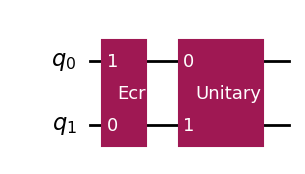

In [8]:
# Get some random unitary:
from qiskit.quantum_info import random_unitary
num_qubits = 2

# Create the quantum circuit:
qr = QuantumRegister(num_qubits, 'q')
circ = QuantumCircuit(qr)
circ.ecr(1,0)
circ.unitary(C, qr)

circ.draw('mpl')

In [9]:
display(array_to_latex(Statevector.from_instruction(circ), prefix="\\text{Statevector} = "))

<IPython.core.display.Latex object>

In [10]:
backend = FakeBrisbane()

# Transpile the ideal circuit to a circuit that can be directly executed by the backend
t_circuit = transpile(circ, backend)
#t_circuit.draw('mpl', style="iqp")

In [4]:
#RC gate 

theta1 = np.pi/4
phi1 = np.pi

theta2 = -np.pi/4
phi2 = np.pi


U1 = np.array(
            [[np.cos(theta1/2), -1J*np.sin(theta1/2) * np.exp(-1J * phi1), 0, 0],
             [-1J*np.sin(theta1/2) * np.exp(1J * phi1), np.cos(theta1/2), 0, 0],
             [0, 0, np.cos(theta1/2), 1J*np.sin(theta1/2) * np.exp(-1J * phi1)],
             [0, 0, 1J*np.sin(theta1/2) * np.exp(1J * phi1), np.cos(theta1/2)]])

U2 = np.array(
            [[np.cos(theta2/2), -1J*np.sin(theta2/2) * np.exp(-1J * phi2), 0, 0],
             [-1J*np.sin(theta2/2) * np.exp(1J * phi2), np.cos(theta2/2), 0, 0],
             [0, 0, np.cos(theta2/2), 1J*np.sin(theta2/2) * np.exp(-1J * phi2)],
             [0, 0, 1J*np.sin(theta2/2) * np.exp(1J * phi2), np.cos(theta2/2)]])


# x gate

theta3 = np.pi
phi3 = 0

X =  -1j*np.array(
            [[np.cos(theta3/2), - 1J * np.sin(theta3/2) * np.exp(-1J * phi3)],
             [- 1J * np.sin(theta3/2) * np.exp(1J * phi3), np.cos(theta3/2)]]
        )

# relazation

theta_I = 0
phi_I = np.pi

I = np.array(
            [[np.cos(theta_I/2), - 1J * np.sin(theta_I/2) * np.exp(-1J * phi_I)],
             [- 1J * np.sin(theta_I/2) * np.exp(1J * phi_I), np.cos(theta_I/2)]]
        )

# sx gates

theta = np.pi/2
phi_sx_1 = np.pi/2
phi_sx_2 = np.pi/2
phi_sx_3 = np.pi/2
phi_sx_4 = np.pi/2


Sx1 = np.array(
            [[np.cos(theta/2), - 1J * np.sin(theta/2) * np.exp(-1J * phi_sx_1)],
             [- 1J * np.sin(theta/2) * np.exp(1J * phi_sx_1), np.cos(theta/2)]])

Sx2 = np.array(
            [[np.cos(theta/2), - 1J * np.sin(theta/2) * np.exp(-1J * phi_sx_2)],
             [- 1J * np.sin(theta/2) * np.exp(1J * phi_sx_2), np.cos(theta/2)]])

Sx3 = np.array(
            [[np.cos(theta/2), - 1J * np.sin(theta/2) * np.exp(-1J * phi_sx_3)],
             [- 1J * np.sin(theta/2) * np.exp(1J * phi_sx_3), np.cos(theta/2)]])

Sx4 = np.array(
            [[np.cos(theta/2), - 1J * np.sin(theta/2) * np.exp(-1J * phi_sx_4)],
             [- 1J * np.sin(theta/2) * np.exp(1J * phi_sx_4), np.cos(theta/2)]])

theta_fix = np.pi
phi_fix = np.pi/2

U_fix = np.array(
            [[np.cos(theta_fix/2), - 1J * np.sin(theta_fix/2) * np.exp(-1J * phi_fix)],
             [- 1J * np.sin(theta_fix/2) * np.exp(1J * phi_fix), np.cos(theta_fix/2)]])


ECR_inv = 1j* np.kron(Sx1, Sx2) @ (U1 @ np.kron (X,I) @ U2 )  @ np.kron(Sx3, Sx4) 

print(ECR_inv* np.sqrt(2))


[[ 0.+0.j  1.-0.j -0.-0.j  0.+1.j]
 [ 1.-0.j -0.+0.j -0.-1.j -0.-0.j]
 [ 0.-0.j -0.+1.j -0.+0.j  1.+0.j]
 [-0.-1.j  0.-0.j  1.-0.j  0.+0.j]]


In [8]:
ecr_in = ECRInvFactory(integr)



ecr_in_gate = ecr_in.construct(0, 0, 6.6e-07, 0.01167643, p[0], p[1], T1[0], T2[0], T1[1], T2[1])
print(ecr_in_gate*np.sqrt(2))


[[-0.0479+0.0282j  1.1389+0.0397j -0.0516-0.0406j -0.2052+1.094j ]
 [ 0.8591-0.0854j  0.052 -0.0019j  0.0913-0.8777j  0.0349-0.0174j]
 [-0.0504-0.0095j  0.2174+0.8502j -0.0561+0.015j   0.8724+0.0855j]
 [-0.0887-1.1357j  0.0425-0.0396j  1.1154+0.004j   0.0482+0.0096j]]


In [9]:
print(np.abs(ecr_in_gate)**2)

[[0.0015 0.6494 0.0022 0.6194]
 [0.3726 0.0014 0.3894 0.0008]
 [0.0013 0.3851 0.0017 0.3842]
 [0.6489 0.0017 0.6221 0.0012]]


In [15]:
cnot = CNOTFactory(integr)

cnot_gate = cnot.construct(0, 0, 6.6e-07, 0.01167643, p[0], p[1], T1[0], T2[0], T1[1], T2[1])

print(cnot_gate)

print(np.abs(cnot_gate)**2)

[[ 0.0628+0.9892j -0.08  -0.0514j -0.0537-0.0327j -0.0335+0.0333j]
 [-0.0526+0.0565j  0.0219+0.9957j -0.0401+0.0305j -0.0526-0.0335j]
 [ 0.0027-0.0411j -0.0282-0.014j  -0.0247-0.0695j -0.9865-0.014j ]
 [-0.0274-0.0177j  0.0074-0.0397j -0.9763-0.075j   0.0318-0.0567j]]
[[0.9825 0.009  0.004  0.0022]
 [0.006  0.9919 0.0025 0.0039]
 [0.0017 0.001  0.0054 0.9734]
 [0.0011 0.0016 0.9589 0.0042]]


In [16]:
cnot_inv = CNOTInvFactory(integr)

cnot_inv_gate = cnot_inv.construct(0, 0, 6.6e-07, 0.01167643, p[0], p[1], T1[0], T2[0], T1[1], T2[1])

print(cnot_inv_gate)

print(np.abs(cnot_inv_gate)**2)

[[-0.798 -0.5884j  0.0294+0.0362j  0.0495+0.0121j -0.0531+0.0237j]
 [-0.1929+0.099j  -0.0402+0.0841j  0.0378-0.0426j  0.7994-0.5653j]
 [-0.0701+0.0218j  0.0228+0.0523j -0.6623+0.7347j  0.0433-0.017j ]
 [-0.0392-0.0138j -0.6537-0.7257j  0.0944+0.1925j -0.0475-0.0973j]]
[[0.983  0.0022 0.0026 0.0034]
 [0.047  0.0087 0.0032 0.9587]
 [0.0054 0.0032 0.9785 0.0022]
 [0.0017 0.9541 0.046  0.0117]]
